# Parks Data

In this notebook, I will analyze parks in the regions of South LA and West LA, respectively. The data set, which I pulled from here [https://egis-lacounty.hub.arcgis.com/datasets/lacounty::countywide-parks-and-open-space-public-hosted/about] was edited previously on Excel since there were several data in here which was unneccesary for our project.

## Import libraries

In [70]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata
import seaborn as sns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

## Import data as a CSV

In [71]:
df = pd.read_csv('Parks_and_Open_Space_edited.csv')

In [72]:
df.shape

(367, 14)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PARK_NAME      367 non-null    object 
 1   ACCESS_TYP     367 non-null    object 
 2   GIS_ACRES      367 non-null    float64
 3   AGNCY_NAME     367 non-null    object 
 4   AGNCY_TYP      367 non-null    object 
 5   TYPE           367 non-null    object 
 6   CENTER_LAT     367 non-null    float64
 7   CENTER_LON     367 non-null    float64
 8   ADDRESS        367 non-null    object 
 9   CITY           367 non-null    object 
 10  ZIP            367 non-null    int64  
 11  IS_COUNTY      367 non-null    object 
 12  Shape__Area    367 non-null    float64
 13  Shape__Length  367 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 40.3+ KB


In [74]:
df.head()

,PARK_NAME,ACCESS_TYP,GIS_ACRES,AGNCY_NAME,AGNCY_TYP,TYPE,CENTER_LAT,CENTER_LON,ADDRESS,CITY,ZIP,IS_COUNTY,Shape__Area,Shape__Length
0,El Parque Nuestro,Open Access,0.530985,"Los Angeles, County of",County Agency,Local Park,33.982364,-118.243713,1675 Gage Ave.,Los Angeles,90001,Yes,23129.625000,738.919654
1,Mary M. Bethune Park,Open Access,5.314878,"Los Angeles, County of",County Agency,Local Park,33.983620,-118.253036,1244 E. 61st St.,Los Angeles,90001,Yes,231515.165000,1990.206873
2,Watts Towers of Simon Rodia State Historic Park,Open Access,0.108213,California Department of Parks and Recreation,State Agency,Regional Open Space,33.938734,-118.241115,1727 E 107th St,Los Angeles,90002,No,4713.720703,356.757393
3,WAYS Reading and Fitness Park,Open Access,0.387581,Heal the Bay,Non Profit - Other,Regional Open Space,33.958788,-118.260862,5115 Wilshire Blvd e,Los Angeles,90002,No,16882.944340,665.351528
4,Metro Blue Line Open Space/Parkway,Open Access,3.646698,Los Angeles County Metropolitan Transportation...,Transportation Agency,Natural Areas,33.948178,-118.243146,7225 Graham Ave,Los Angeles,90002,No,158849.508800,7322.743882


In [75]:
gdf = gpd.GeoDataFrame(df, 
                     crs='EPSG:4326',
                     geometry=gpd.points_from_xy(df.CENTER_LON, df.CENTER_LAT))

In [76]:
gdf.lon = gdf.CENTER_LON.astype('float')
gdf.lat = gdf.CENTER_LAT.astype('float')

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:182: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


In [78]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PARK_NAME      367 non-null    object  
 1   ACCESS_TYP     367 non-null    object  
 2   GIS_ACRES      367 non-null    float64 
 3   AGNCY_NAME     367 non-null    object  
 4   AGNCY_TYP      367 non-null    object  
 5   TYPE           367 non-null    object  
 6   CENTER_LAT     367 non-null    float64 
 7   CENTER_LON     367 non-null    float64 
 8   ADDRESS        367 non-null    object  
 9   CITY           367 non-null    object  
 10  ZIP            367 non-null    int64   
 11  IS_COUNTY      367 non-null    object  
 12  Shape__Area    367 non-null    float64 
 13  Shape__Length  367 non-null    float64 
 14  geometry       367 non-null    geometry
dtypes: float64(5), geometry(1), int64(1), object(8)
memory usage: 43.1+ KB


It is important to note that we now have a geometry column which we will use to plot and use our point pattern analysis.

In [79]:
gdf=gdf[['PARK_NAME','ACCESS_TYP','GIS_ACRES','AGNCY_NAME','AGNCY_TYP','TYPE','ADDRESS','CITY','ZIP','IS_COUNTY','geometry']]

I am filtering the columns that I need in order to support my data analysis.

In [80]:
gdf.columns = ['park_name','access_type','acres','agency_name','agency_type','park_type','address','city','zip','is_county','geometry']

In [81]:
gdf.head()

,park_name,access_type,acres,agency_name,agency_type,park_type,address,city,zip,is_county,geometry
0,El Parque Nuestro,Open Access,0.530985,"Los Angeles, County of",County Agency,Local Park,1675 Gage Ave.,Los Angeles,90001,Yes,POINT (-118.24371 33.98236)
1,Mary M. Bethune Park,Open Access,5.314878,"Los Angeles, County of",County Agency,Local Park,1244 E. 61st St.,Los Angeles,90001,Yes,POINT (-118.25304 33.98362)
2,Watts Towers of Simon Rodia State Historic Park,Open Access,0.108213,California Department of Parks and Recreation,State Agency,Regional Open Space,1727 E 107th St,Los Angeles,90002,No,POINT (-118.24111 33.93873)
3,WAYS Reading and Fitness Park,Open Access,0.387581,Heal the Bay,Non Profit - Other,Regional Open Space,5115 Wilshire Blvd e,Los Angeles,90002,No,POINT (-118.26086 33.95879)
4,Metro Blue Line Open Space/Parkway,Open Access,3.646698,Los Angeles County Metropolitan Transportation...,Transportation Agency,Natural Areas,7225 Graham Ave,Los Angeles,90002,No,POINT (-118.24315 33.94818)


To confirm I like my column names, I check another of the first 5 data entries.

### Let's use a heat map to visualize point densities of open access to parks in our respective regions!

<AxesSubplot:>

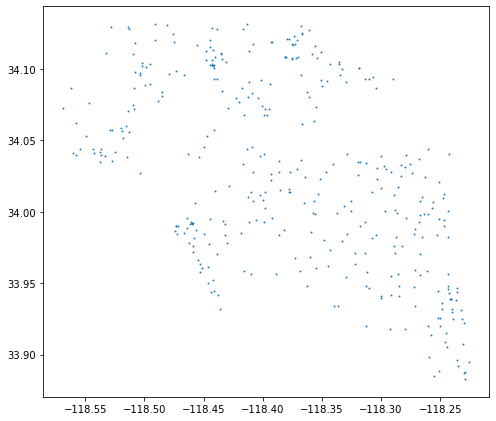

In [82]:
gdf.plot(figsize=(8, 8),
             markersize=0.8)

Hmm... This shows us a piece of the narrative, but it is important that we add more characteristics in order to further support the narrative of which region has more access to open parks.

In [83]:
gdf.access_type.value_counts()

Open Access          308
Restricted Access     21
No Public Access      19
Unknown Access        19
Name: access_type, dtype: int64

In [84]:
park_characteristics = gdf.access_type.value_counts().index.tolist()
park_characteristics

['Open Access', 'Restricted Access', 'No Public Access', 'Unknown Access']

In [85]:
gdf[gdf.access_type == 'Open Access'].head()

,park_name,access_type,acres,agency_name,agency_type,park_type,address,city,zip,is_county,geometry
0,El Parque Nuestro,Open Access,0.530985,"Los Angeles, County of",County Agency,Local Park,1675 Gage Ave.,Los Angeles,90001,Yes,POINT (-118.24371 33.98236)
1,Mary M. Bethune Park,Open Access,5.314878,"Los Angeles, County of",County Agency,Local Park,1244 E. 61st St.,Los Angeles,90001,Yes,POINT (-118.25304 33.98362)
2,Watts Towers of Simon Rodia State Historic Park,Open Access,0.108213,California Department of Parks and Recreation,State Agency,Regional Open Space,1727 E 107th St,Los Angeles,90002,No,POINT (-118.24111 33.93873)
3,WAYS Reading and Fitness Park,Open Access,0.387581,Heal the Bay,Non Profit - Other,Regional Open Space,5115 Wilshire Blvd e,Los Angeles,90002,No,POINT (-118.26086 33.95879)
4,Metro Blue Line Open Space/Parkway,Open Access,3.646698,Los Angeles County Metropolitan Transportation...,Transportation Agency,Natural Areas,7225 Graham Ave,Los Angeles,90002,No,POINT (-118.24315 33.94818)


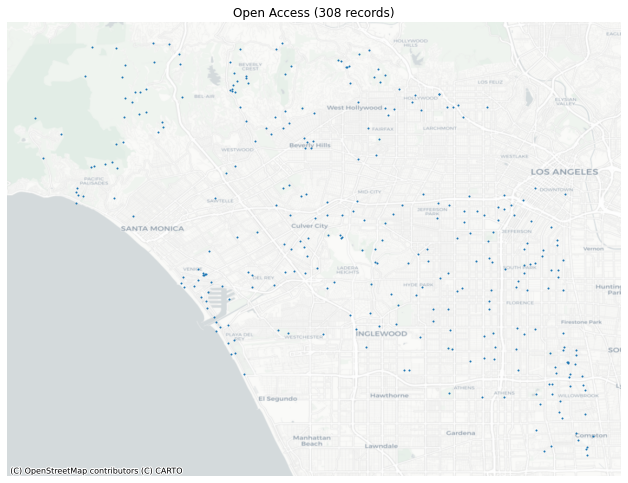

In [87]:
access_type = 'Open Access'

ax = gdf[gdf.access_type == access_type].plot(figsize=(11,11), markersize=1)

ax.set_title(access_type + ' (' + str(gdf[gdf.access_type == access_type].shape[0]) + ' records)')

ax.axis('off')

ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

## Trying out Seaborn Plots

In [88]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

In order to use seaborn plots, I first must create separate columns for lat and lon.

In [89]:
gdf.head()

,park_name,access_type,acres,agency_name,agency_type,park_type,address,city,zip,is_county,geometry,x,y
0,El Parque Nuestro,Open Access,0.530985,"Los Angeles, County of",County Agency,Local Park,1675 Gage Ave.,Los Angeles,90001,Yes,POINT (-118.24371 33.98236),-118.243713,33.982364
1,Mary M. Bethune Park,Open Access,5.314878,"Los Angeles, County of",County Agency,Local Park,1244 E. 61st St.,Los Angeles,90001,Yes,POINT (-118.25304 33.98362),-118.253036,33.983620
2,Watts Towers of Simon Rodia State Historic Park,Open Access,0.108213,California Department of Parks and Recreation,State Agency,Regional Open Space,1727 E 107th St,Los Angeles,90002,No,POINT (-118.24111 33.93873),-118.241115,33.938734
3,WAYS Reading and Fitness Park,Open Access,0.387581,Heal the Bay,Non Profit - Other,Regional Open Space,5115 Wilshire Blvd e,Los Angeles,90002,No,POINT (-118.26086 33.95879),-118.260862,33.958788
4,Metro Blue Line Open Space/Parkway,Open Access,3.646698,Los Angeles County Metropolitan Transportation...,Transportation Agency,Natural Areas,7225 Graham Ave,Los Angeles,90002,No,POINT (-118.24315 33.94818),-118.243146,33.948178


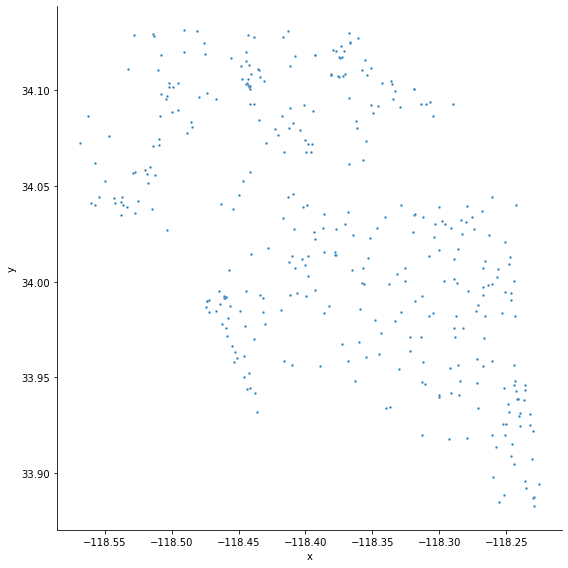

In [93]:
sns.relplot(data=gdf,
            x='x', 
            y='y',
            s=6, # size of point
            height=8 # size of plot
           )

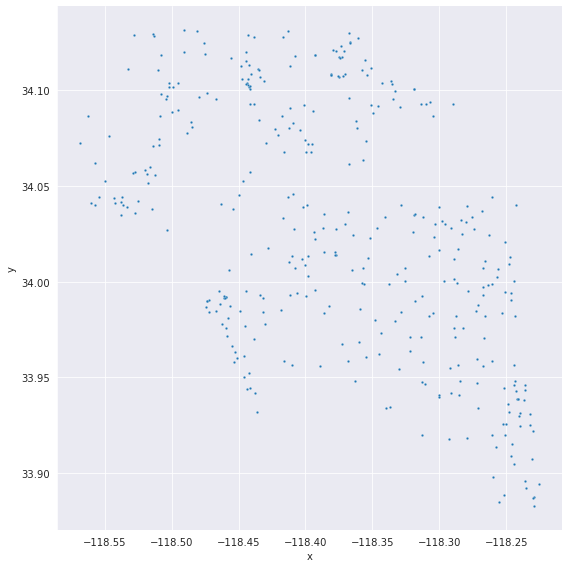

In [94]:
# seaborn comes with themes to make them prettier
sns.set_style('darkgrid')

# scatterplot 
sns.relplot(data=gdf,
            x='x', 
            y='y',
            s=6,
            height=8)

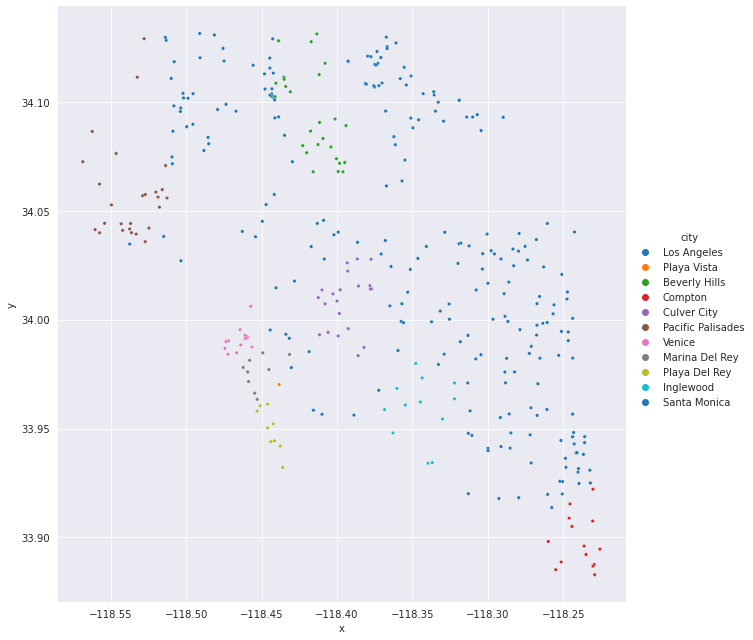

In [109]:
# scatterplot colored by area
sns.relplot(data=gdf,
            x='x', 
            y='y',
            hue='city',
            palette='tab10',
            s=12,
            height=9)

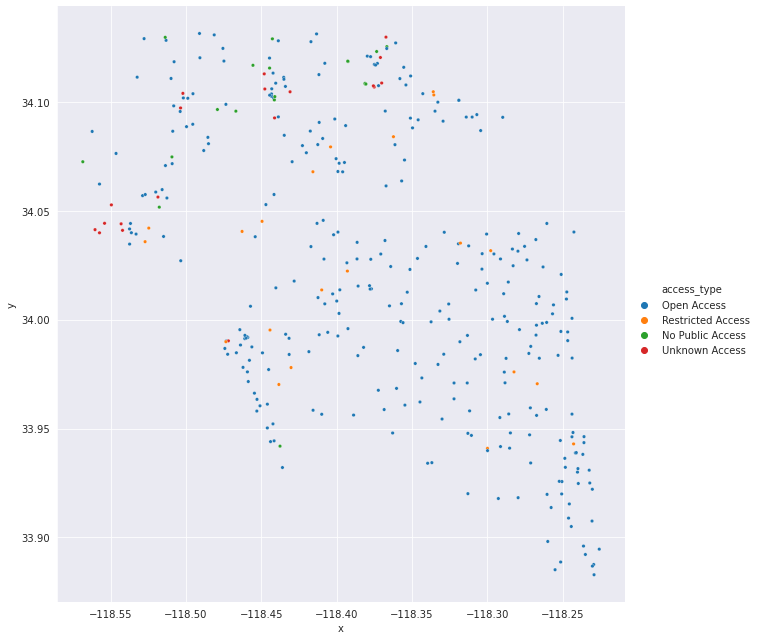

In [108]:
sns.relplot(data=gdf,
            x='x', 
            y='y',
            hue='access_type',
            palette='tab10',
            s=12,
            height=9)

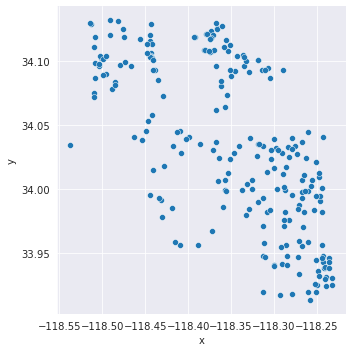

In [110]:
sns.relplot(data=gdf[gdf['city']=='Los Angeles'],
            x='x', 
            y='y')

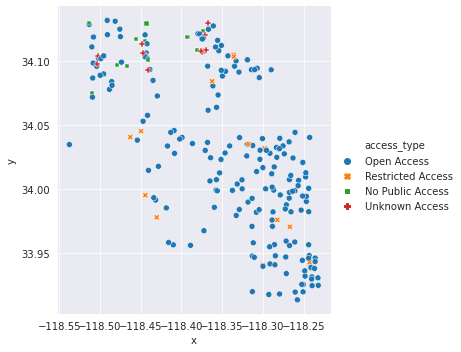

In [115]:
sns.relplot(data=gdf[gdf['city']=='Los Angeles'],
            x='x', 
            y='y',
            hue='access_type',
           style='access_type')

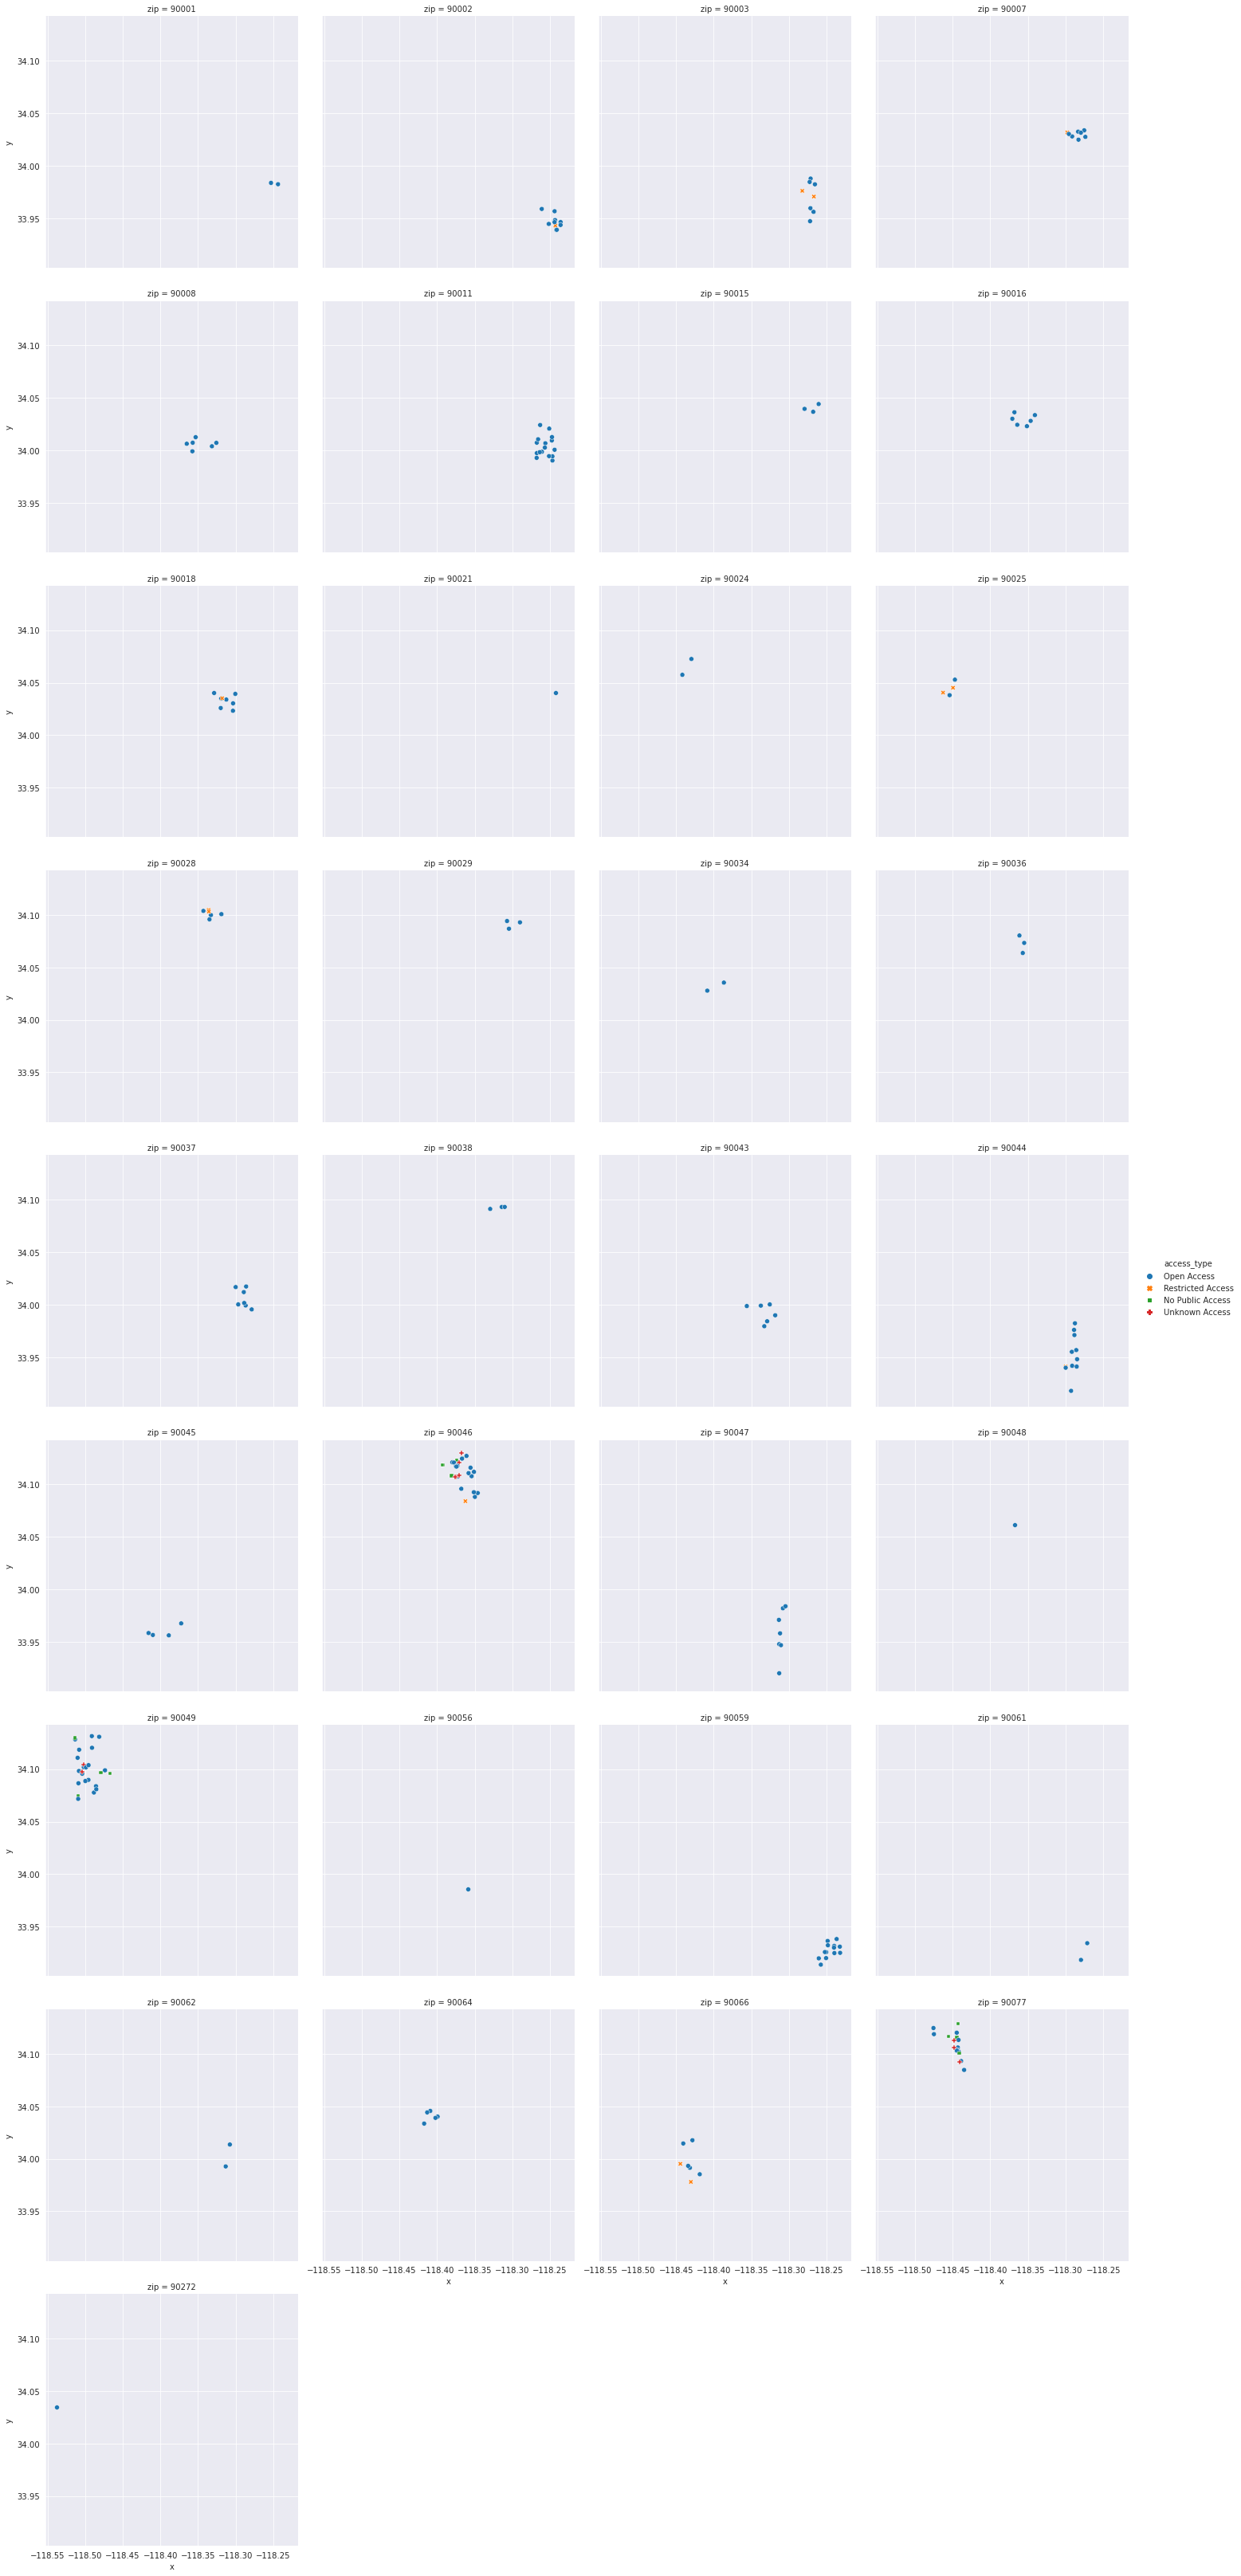

In [116]:
sns.relplot(data=gdf[gdf['city']=='Los Angeles'],
            x='x', 
            y='y',
            hue='access_type',
           style='access_type',
           col='zip',
            col_wrap=4)

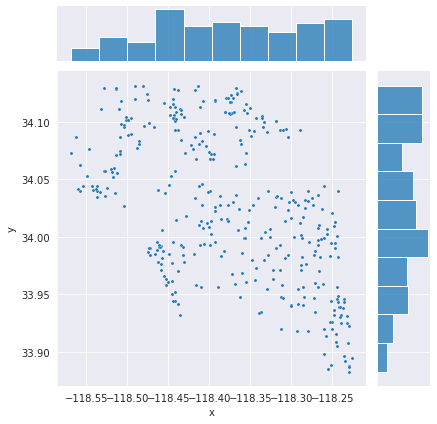

In [117]:
g = sns.jointplot(data = gdf,
                  x='x', 
                  y='y',
                  s=10)

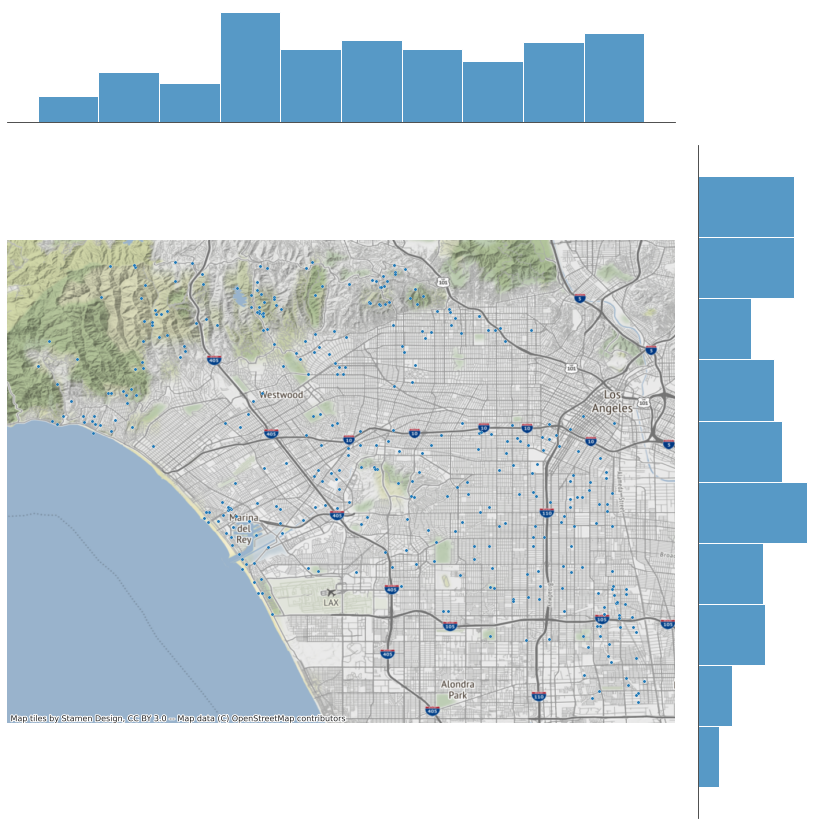

In [119]:

sns.set_style('white')
g = sns.jointplot(data = gdf,
                  x='x', 
                  y='y',
                  s=10,
                  height=12
                 )

g.ax_joint.set_axis_off()


ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

(-118.58569412537713, -118.20856297462286, 33.8704180775, 34.1439091525)

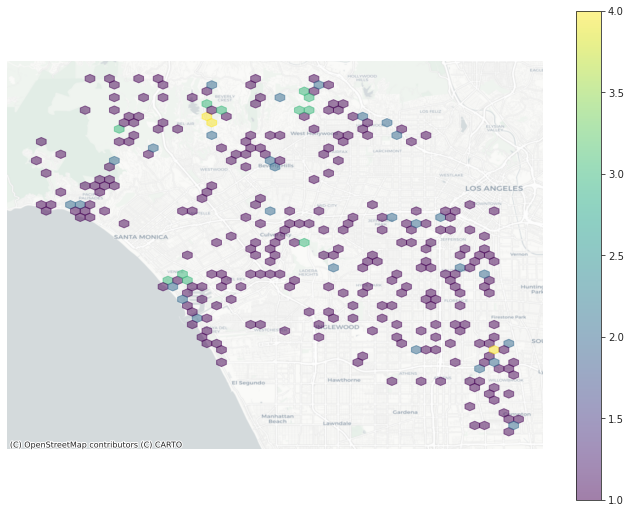

In [120]:
# Set up figure and axis
f, ax = plt.subplots(figsize=(12, 9))

# Generate and add hexbin with 50 hexagons in each 
# dimension, half transparency, ommitting grids with no crime,
# and using the viridis colormap
hb = ax.hexbin(
    x = gdf['x'], 
    y = gdf['y'],
    gridsize=50, 
    linewidths=1,
    alpha=0.5, 
    mincnt=1, # don't show zero
    cmap='viridis'
)

# Add basemap
ctx.add_basemap(
    ax, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

# Add colorbar
plt.colorbar(hb)

# Remove axes
ax.axis('off')

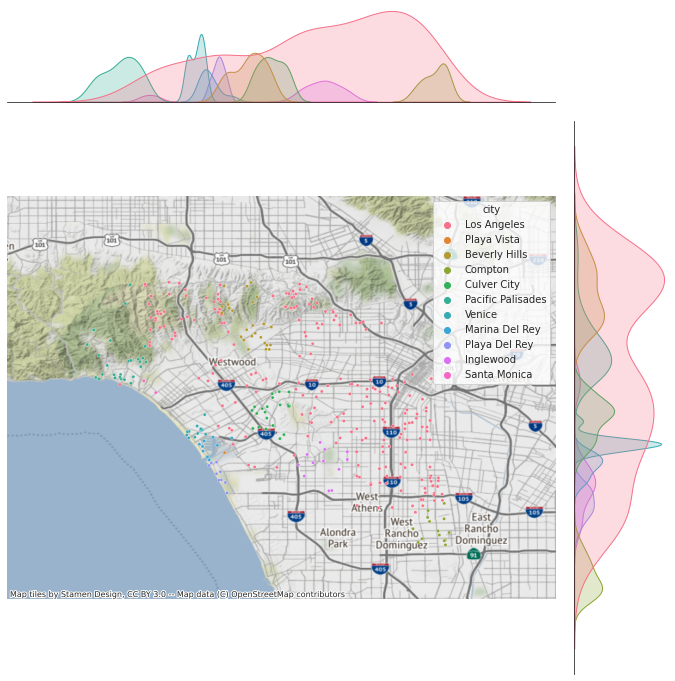

In [125]:
# color code by race
g = sns.jointplot(data = gdf,
                  x='x', 
                  y='y',
                  hue='city',
                  s=10,
                  height=10 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')